# Unitary Fermion Gas in BCC lattice

* Compute g.s. energy of fermions in unitary limit coupling strength.
* N=66 nucleons in one flavor with two spin states are placed in the BCC lattice 
  in cubic boundary with length L 
* Results of each code run is summarized in summary_L[A]Lto[B].dat files  
  A corresponds to Length of a Box in unit of lattice spacing 
  B corresponds to choice of Lt_outer parameter in the calculation 
* cutoff = 100 MeV 
  tcutoff = 200 MeV are used. 

## Import/Read

In [1]:
from __future__ import print_function
from numpy import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import *
from scipy import optimize 
import myutil
import glob

path = './BCC/'

### Read results 
Results are read from external files and stored as a dictionary

* result_free  : energy for N=66 fermion without interaction (using MATLAB )
* result_cubic : results from Longzeng for cubic lattice.
* result_bcc   : energy for N=66 fermion with interaction in Unitary limit
*  keys= L or (L, Lto)
*  'L' : lattice size
*  'Lto' : Lt_outer
*  'Lt'  :Lt_inner
*  'beta_fin' : ratio with energy of free particles
*  'beta_therm': ratio with energy from thermodynamic expression
*  'EH0'   : Hamiltonian energy 
*  'EM0'   : Transfer energy 
*  'FG'    : Thermodynamic expression 

#### Cubic Lattice results

In [2]:
# read results from cubic lattice 
out_cubic = myutil.read_fresco_res(path+'02_Cubic.dat')
for key in out_cubic.keys():
    out_cubic[key]=np.array(out_cubic[key])

# dictionary for cubic lattice results 
result_cubic={}
for n in [0,1,2,3,4,5,6]:
    result_cubic[n+5] = {}
    result_cubic[n+5]['L'] = n+5
    result_cubic[n+5]['Lt'] = out_cubic[2*n][:,0]
    result_cubic[n+5]['beta_therm'] = out_cubic[2*n][:,1:3]
    result_cubic[n+5]['beta_fin'] = out_cubic[2*n+1][:,1:3]

#### Free Fermion gas energy in BCC lattice


In [3]:
#read summary_free.dat
result_free={}
out=np.loadtxt(path+'summary_free.dat')
for n in range(4,4+len(out)):
    result_free[n]={}
    result_free[n]['L']=n
    result_free[n]['exact']=out[n-4,1]
    result_free[n]['EH0']=out[n-4,2]
    result_free[n]['EM0']=out[n-4,3]
    result_free[n]['FG']=out[n-4,4]

print('L  E_finite  E_thermo')
for n in [4,5,6,7,8,9,10,11]:
    print('%3i %8.3f  %8.3f'    %(n, result_free[n]['EM0'], result_free[n]['FG'])     )

L  E_finite  E_thermo
  4 2041.526  2060.123
  5 1308.889  1318.479
  6  913.620   915.610
  7  671.836   672.693
  8  514.274   515.031
  9  406.162   406.938
 10  328.845   329.620
 11  271.667   272.413


#### Fit the ratio thermo/finite

Use a fitting function to fit the ratio as a function of density. 
The fitting is done with $L<=11$ and compared with result with $L>11$.


ratio fits a=0.995053 +/- 0.000290
[0.99505317 1.78972506 0.6761731  1.26223225]
[[ 8.43566963e-08 -2.85288956e-05  1.03555023e-07 -2.02003200e-05]
 [-2.85288956e-05  1.37011528e-02  6.15949521e-05  9.83140041e-03]
 [ 1.03555023e-07  6.15949521e-05  4.44080173e-06  4.95685018e-05]
 [-2.02003200e-05  9.83140041e-03  4.95685018e-05  7.06166571e-03]]


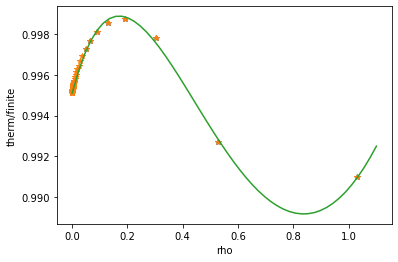

In [4]:
L=np.array([4,5,6,7,8,9,10,11]);
rho = 66./L**3
ratio_fin = np.array([ 1/result_free[n]['EM0'] for n in L])
ratio_therm = np.array([ 1/result_free[n]['FG'] for n in L])
plt.plot(rho , ratio_therm/ratio_fin,'*')
plt.xlabel('rho')
plt.ylabel('therm/finite')

#----more points------------------------------
#  Free energy are calculated for L> 11 too. 
tempL=np.array([n for n in range(4,4+len(out))])    
temp_ratio=np.array([ result_free[n]['EM0']/result_free[n]['FG'] for n in range(4,4+len(out))])
plt.plot(66./tempL**3,temp_ratio,'*')
#----------------------------------------------

def ratio_fit(x,a,b,c,d):
    return a+b*(np.exp(-c*x)-1)+d*np.log(x+1)

xdata = rho
ydata = ratio_therm/ratio_fin
#--fitting is done using up to L=11
params, p_covariance = optimize.curve_fit(ratio_fit , xdata , ydata, p0=(1,1,1,1) )
print('ratio fits a=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
xx=np.linspace(0.001,1.1,50)
ff = ratio_fit(xx,*params)
ratio_fit_para=params
plt.plot(xx,ff)
print(params)
print(p_covariance)

* However, since the small L limit shows some-what unnatural behavior, we will not use this fitting function.
  And rather only use the ratio value 0.995 at large L. 

### Read BCC results

From 'summary_L..' files 

In [5]:
# read summary files 
summary_list = glob.glob(path+'summary_L*')
result_bcc={}
for i in summary_list:
    L=int(i[i.find('L')+1:i.find('L')+3])
    Lto=int(i[i.find('Lto')+3:i.find('Lto')+4 ])
    out=np.loadtxt(i)
    result_bcc[L,Lto]={}
    result_bcc[L,Lto]['Lt']=out[:,2] 
    result_bcc[L,Lto]['EH0']=out[:,3:5]
    result_bcc[L,Lto]['EM0']=out[:,5:7]
    result_bcc[L,Lto]['ntot']=out[:,7]
    result_bcc[L,Lto]['nprocs']=out[:,8]
    result_bcc[L,Lto]['beta_fin']=result_bcc[L,Lto]['EM0']/result_free[L]['EM0']
    result_bcc[L,Lto]['beta_therm']=result_bcc[L,Lto]['EM0']/result_free[L]['FG']  

### functions to be used for euclidean time extrapolation

In [6]:
# fitting function for large Lt limit
def fit_exp(t,E0,b,eta):
    return E0+b*np.exp(-eta*t)

def print_beta(dictionary,L,Lto,beta):
    """ print contents of a BCC code result
        input dictionary is bcc_result[L,Lto]   
    """
    print('L=%i  Lt_outer=%i'%(L,Lto))
    print('Lt  %s '%(beta))
    for i in range(len(dictionary['Lt'])):
        print('%i  %f   %f'%(dictionary['Lt'][i], 
                         dictionary[beta][i,0], dictionary[beta][i,1]))
    return    

def plot_beta(dictionary,L,Lto,beta,lattice='BCC'):
    """ errorbar plot for Lt dependence 
        
    """
    if lattice=='BCC':
        label='%5s L=%i Lt_outer=%i '%(lattice,L,Lto)
    else :
        label='%5s L=%i           '%(lattice,L)
    plt.errorbar(dictionary['Lt'], 
             dictionary[beta][:,0], yerr=dictionary[beta][:,1]
             ,fmt='o',label = label)
    return 

def fit_beta_Lt(dictionary, L,Lto, beta
                , lattice='BCC', p0=[0.3,0.1,0.01],fit_func=fit_exp
                ,fit_start_index=None,fit_end_index=None
                ,plot=None):
    """ fit Lt_dependence of beta
        and plot 
    """
    if lattice=='BCC':
        label='%5s L=%i Lt_outer=%i'%(lattice, L, Lto)
    else:
        label='%5s L=%i           '%(lattice, L)
        
    params, p_covariance = optimize.curve_fit(fit_func, dictionary['Lt'][fit_start_index:fit_end_index]
                                          , dictionary[beta][fit_start_index:fit_end_index,0]
                                          , sigma=dictionary[beta][fit_start_index:fit_end_index,1]
                                          , p0 = p0)
    
    print(label+' %8s E0=%f +/- %f   b=%f  eta=%f  '%(
                   beta, params[0],np.sqrt(p_covariance[0,0]) ,params[1],params[2] ) )
    if plot:
        xx = np.arange(0,1000,10)
        ff = fit_func(xx,*params)
        plt.errorbar(dictionary['Lt']
             ,dictionary[beta][:,0]
             ,yerr=dictionary[beta][:,1]
                 ,fmt='.', label=label     )
        plt.plot(xx,ff,label=label  )  
        plt.xlabel('Lt')
        plt.ylabel('MeV')
    return [params[0], np.sqrt(p_covariance[0,0]),params[1],params[2]]

# storage for fitted results  
result_bcc['fit']={}
result_bcc['fit']['beta_fin']={}
result_bcc['fit']['beta_therm']={}

## Plot results L=4

No cubic lattice result is available for L=4

L=4  Lt_outer=0
Lt  EM0 
100  753.400000   0.149600
150  685.600000   0.214000
200  662.800000   0.242400
250  658.000000   0.261700
300  656.400000   0.309800
350  656.200000   0.315800
400  655.700000   0.300300
500  655.800000   0.281900
600  654.900000   0.502700
L=4  Lt_outer=5
Lt  EM0 
100  661.300000   0.441900
200  653.700000   0.599100
300  654.700000   0.392600
400  654.800000   0.400500
500  651.800000   0.517800
600  651.900000   0.580300
700  653.500000   0.439300


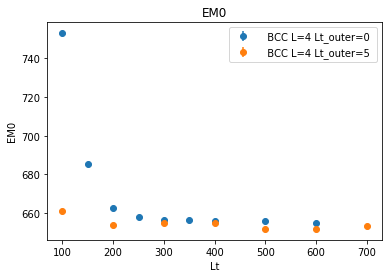

In [7]:
L=4;
# print energy 
# print table 
for Lto in [0,5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'EM0')

plt.figure()
for Lto in [0,5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'EM0')
plt.title('EM0')
plt.xlabel('Lt');
plt.ylabel('EM0')
plt.legend()  ;

## Fitting L=4 results

  BCC L=4 Lt_outer=0      EM0 E0=655.391943 +/- 0.407359   b=1081.683120  eta=0.024007  
     beta_fin= 0.321030 +/- 0.000200
     beta_therm= 0.318132 +/- 0.000198
  BCC L=4 Lt_outer=5      EM0 E0=653.693553 +/- 0.616654   b=2988.305006  eta=0.059735  
     beta_fin= 0.320198 +/- 0.000302
     beta_therm= 0.317308 +/- 0.000299


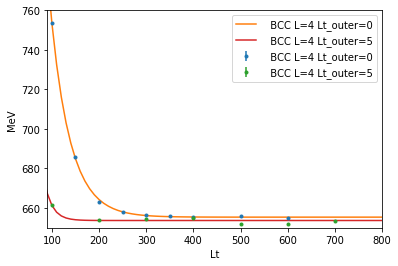

In [8]:
# storage for fitted results  
result_bcc['fit']={}
result_bcc['fit']['beta_fin']={}
result_bcc['fit']['beta_therm']={}


def fit_exp(t,E0,b,eta):
    return E0+b*np.exp(-eta*t)

L=4;
p0=[660,200,0.01]

Lto=0;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=None,fit_end_index=None
                ,plot=True)
print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=None,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([650,760]);plt.xlim([90,800])
plt.legend()



### Comment
* Lt_outer=5 case seems not fit well in Large Lt. (Oscillating)
* One may choose Lt_outer=0 fitting for large Lt limit. 

## Plot results L=5

L=5  Lt_outer=0
Lt  EM0 
100  543.500000   0.158000
200  482.100000   0.310700
300  457.000000   0.342800
400  453.800000   0.731800
500  453.900000   0.352600
600  452.600000   0.450300
L=5  Lt_outer=5
Lt  EM0 
100  475.800000   0.214400
200  456.600000   0.250300
300  454.400000   0.314400
400  453.700000   0.314000
500  454.100000   0.421700
600  454.200000   0.279900
700  454.000000   0.289200
800  454.000000   0.329300


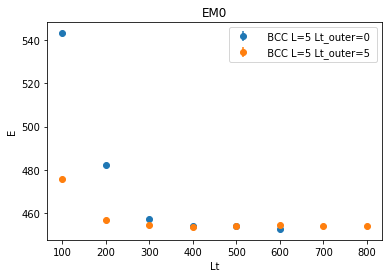

In [9]:
L=5;
# print table 
for Lto in [0,5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'EM0')

# plot
plt.figure()
for Lto in [0,5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'EM0')
    
#plot_beta(result_cubic[L],L,Lto,'EM0',lattice='cubic')

plt.title('EM0')
plt.xlabel('Lt');
plt.ylabel('E')
plt.legend()  ;

## Fitting L=5 results

  BCC L=5 Lt_outer=0      EM0 E0=453.352552 +/- 0.424773   b=1768.291206  eta=0.020596  
     beta_fin= 0.346364 +/- 0.000325
     beta_therm= 0.343845 +/- 0.000322
  BCC L=5 Lt_outer=5      EM0 E0=454.008941 +/- 0.080933   b=183.023360  eta=0.021281  
     beta_fin= 0.346866 +/- 0.000062
     beta_therm= 0.344343 +/- 0.000061


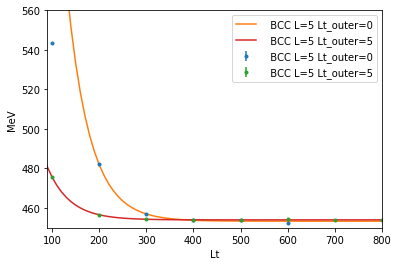

In [10]:
L=5;
p0=[400,200,0.01]
Lto=0;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=1,fit_end_index=None
                ,plot=True)
print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=None,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([450,560]);plt.xlim([90,800])
plt.legend()


cubic L=5            beta_fin E0=0.355387 +/- 0.000278   b=0.040926  eta=0.011170  
cubic L=5            beta_therm E0=0.333694 +/- 0.000261   b=0.038428  eta=0.011170  


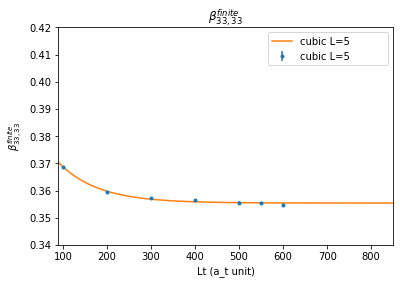

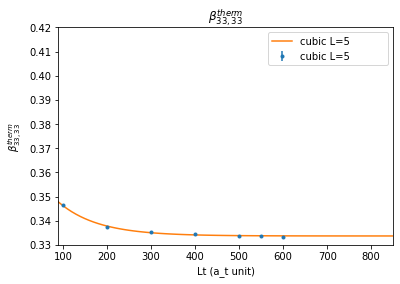

In [11]:
L=5;
# fit and plot for beta_fin
plt.figure()
# fit for cubic 
result_cubic[L]['fit']={}
for beta in ['beta_fin']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)
        
plt.ylim([0.34,0.42])
plt.xlim([90,850])
plt.legend()
plt.title(r'$\beta^{finite}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{finite}_{33,33}$') ;        

# fit for beta_therm
plt.figure()
for beta in ['beta_therm']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.33,0.42]);plt.xlim([90,850]);plt.legend()  
plt.title(r'$\beta^{therm}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{therm}_{33,33}$') ; 

### Comment
* BCC Lt_outer=0 result seems to not fit well with Lt=100 point.   
* BCC Lt_outer=5 result seems to fit well including Lt=100 point
* Fitting omitting Lt=100 shows convergence in Lt_outer 
* cubic beta_fin is larger than BCC values. Can we explain/argue this behavior? 

## Plot results L=6

L=6  Lt_outer=0
Lt  beta_fin 
100  0.442854   0.000105
200  0.407500   0.000167
300  0.369629   0.000278
400  0.359559   0.000433
500  0.357370   0.000433
600  0.357370   0.000452
L=6  Lt_outer=5
Lt  beta_fin 
100  0.401480   0.000138
200  0.366673   0.000186
300  0.357589   0.001341
400  0.357370   0.000311
500  0.357041   0.000286
600  0.355837   0.000646
700  0.355618   0.000596
800  0.357041   0.000336


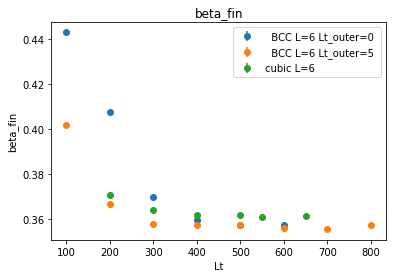

In [12]:
L=6;
# print table 
for Lto in [0,5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'beta_fin')

# plot
plt.figure()
for Lto in [0,5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'beta_fin')
    
plot_beta(result_cubic[L],L,Lto,'beta_fin',lattice='cubic')

plt.title('beta_fin')
plt.xlabel('Lt');
plt.ylabel('beta_fin')
plt.legend()  ;

## Fitting L=6 results

  BCC L=6 Lt_outer=0      EM0 E0=325.917892 +/- 0.302813   b=728.862723  eta=0.013772  
     beta_fin= 0.356733 +/- 0.000331
     beta_therm= 0.355957 +/- 0.000331
  BCC L=6 Lt_outer=5      EM0 E0=325.934845 +/- 0.201693   b=184.266010  eta=0.015061  
     beta_fin= 0.356751 +/- 0.000221
     beta_therm= 0.355975 +/- 0.000220


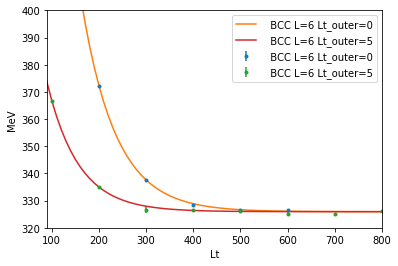

In [13]:
L=6;
p0=[300,200,0.01]
Lto=0;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=1,fit_end_index=None
                ,plot=True)
print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=None,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([320,400]);plt.xlim([90,800])
plt.legend()

cubic L=6            beta_fin E0=0.361015 +/- 0.000203   b=0.115004  eta=0.012541  
cubic L=6            beta_therm E0=0.350247 +/- 0.000196   b=0.111574  eta=0.012541  


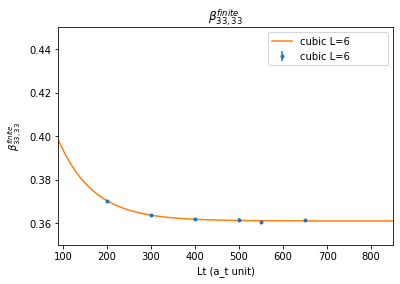

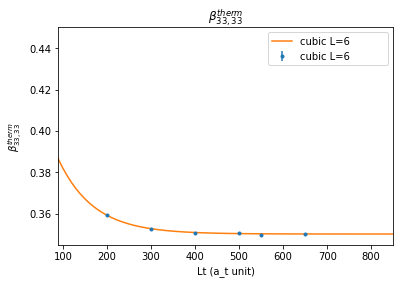

In [14]:
L=6;
plt.figure()
# fit for cubic 
result_cubic[L]['fit']={}
for beta in ['beta_fin']: 
    result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.35,0.45])
plt.xlim([90,850])
plt.legend()
plt.title(r'$\beta^{finite}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{finite}_{33,33}$') ;        

# fit for beta_therm

plt.figure()
for beta in ['beta_therm']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.345,0.45]);plt.xlim([90,850]);plt.legend()
plt.title(r'$\beta^{therm}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{therm}_{33,33}$') ; 

### Comment
* BCC Lt_outer=0 does not fit well for Lt=100. 
* Thus, fitting is done by excluding Lt=100 values for both Lt_outer=0 and 5.
  Can we explain/argue this? 
* cubic and BCC Lt_outer=5 seems to fit well.  (Note that Lt=100 for Lt_outer=5 is not fitted.) 
* large Lt limit value is larger for cubic lattice than BCC lattice. 
  (Though the difference seems to be smaller than the L=5 case) 

## Plot results L=7

L=7  Lt_outer=0
Lt  beta_fin 
100  0.469162   0.000111
200  0.434035   0.000183
300  0.401140   0.000284
400  0.373306   0.000537
500  0.365714   0.000611
600  0.363631   0.000621
700  0.361844   0.000923
L=7  Lt_outer=5
Lt  beta_fin 
100  0.429272   0.000201
200  0.394888   0.000205
300  0.370775   0.000299
400  0.364821   0.000340
500  0.362589   0.000397
600  0.362886   0.000404
700  0.362886   0.000375
800  0.362291   0.000643


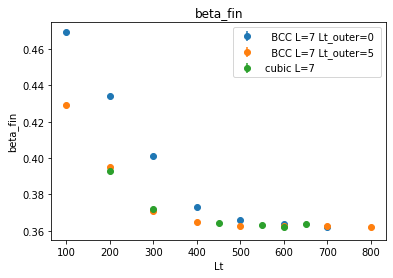

In [15]:
L=7;
# print table 
for Lto in [0,5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'beta_fin')

# plot
plt.figure()
for Lto in [0,5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'beta_fin')
    
plot_beta(result_cubic[L],L,Lto,'beta_fin',lattice='cubic')

plt.title('beta_fin')
plt.xlabel('Lt');
plt.ylabel('beta_fin')
plt.legend()  ;

## Fitting L=7 results

  BCC L=7 Lt_outer=0      EM0 E0=243.489194 +/- 0.301893   b=1136.833568  eta=0.012592  
     beta_fin= 0.362424 +/- 0.000449
     beta_therm= 0.361962 +/- 0.000449
  BCC L=7 Lt_outer=5      EM0 E0=243.599285 +/- 0.124669   b=336.830346  eta=0.013711  
     beta_fin= 0.362588 +/- 0.000186
     beta_therm= 0.362125 +/- 0.000185


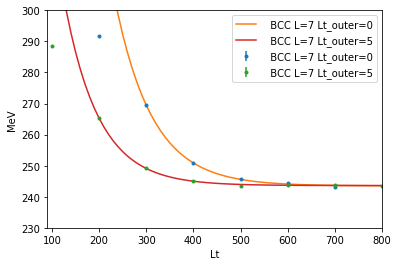

In [16]:
L=7;
p0=[200,200,0.01]

Lto=0;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=2,fit_end_index=None
                ,plot=True)
print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=1,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([230,300]);plt.xlim([90,800])
plt.legend()

cubic L=7            beta_fin E0=0.363041 +/- 0.000409   b=0.321857  eta=0.011928  
cubic L=7            beta_therm E0=0.356946 +/- 0.000402   b=0.316453  eta=0.011928  


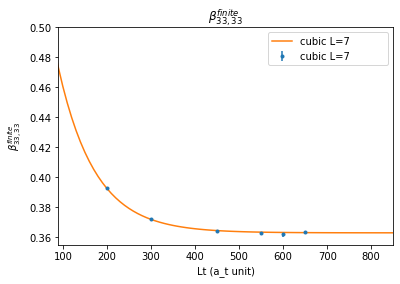

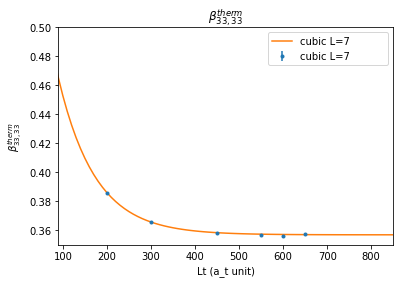

In [17]:
L=7;
plt.figure()
# fit for cubic 
result_cubic[L]['fit']={}
for beta in ['beta_fin']:    
    result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.355,0.5])
plt.xlim([90,850])
plt.legend()
plt.title(r'$\beta^{finite}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{finite}_{33,33}$') ;        

# fit for beta_therm

plt.figure()
for beta in ['beta_therm']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)
 
plt.ylim([0.35,0.5]);plt.xlim([90,850]);plt.legend()            
plt.title(r'$\beta^{therm}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{therm}_{33,33}$') ; 

### Comment
* Lt_outer=0 does not fit well at  Lt=100~200. Fitting is done omiiting those. 
* Lt_outer=5 fitting ommited Lt=100. 

## Plot results L=8

L=8  Lt_outer=0
Lt  beta_fin 
100  0.495261   0.000102
150  0.468233   0.000142
200  0.454233   0.000173
250  0.443732   0.000202
350  0.417482   0.000850
450  0.388509   0.001468
550  0.374120   0.001615
600  0.371203   0.001822
700  0.368092   0.000794
L=8  Lt_outer=5
Lt  beta_fin 
100  0.448399   0.000272
150  0.439066   0.000231
200  0.426232   0.000239
250  0.409898   0.000583
300  0.394537   0.000315
350  0.382481   0.000444
400  0.375286   0.000568
500  0.368870   0.000713
550  0.368870   0.000596
600  0.366925   0.000591
650  0.367120   0.000740
700  0.367508   0.000594
800  0.367508   0.000563
900  0.367314   0.001082


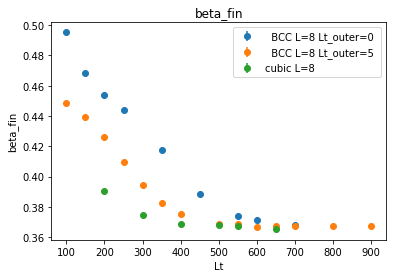

In [18]:
L=8;
# print table 
for Lto in [0,5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'beta_fin')

# plot
plt.figure()
for Lto in [0,5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'beta_fin')
    
plot_beta(result_cubic[L],L,Lto,'beta_fin',lattice='cubic')

plt.title('beta_fin')
plt.xlabel('Lt');
plt.ylabel('beta_fin')
plt.legend()  ;

## Fitting L=8 results

  BCC L=8 Lt_outer=0      EM0 E0=187.758125 +/- 0.397874   b=496.930047  eta=0.008326  
     beta_fin= 0.365094 +/- 0.000774
     beta_therm= 0.364557 +/- 0.000773
  BCC L=8 Lt_outer=5      EM0 E0=188.732009 +/- 0.134461   b=502.416770  eta=0.011889  
     beta_fin= 0.366987 +/- 0.000261
     beta_therm= 0.366448 +/- 0.000261


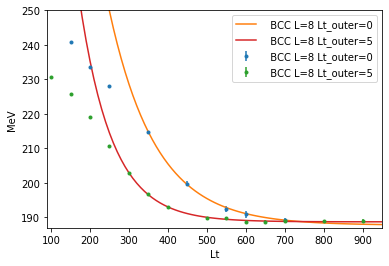

In [19]:
L=8;
p0=[150,200,0.01]

Lto=0;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=4,fit_end_index=None
                ,plot=True)
print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=4,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([187,250]);plt.xlim([90,950])
plt.legend()


cubic L=8            beta_fin E0=0.366180 +/- 0.000547   b=0.190014  eta=0.010332  
cubic L=8            beta_therm E0=0.362177 +/- 0.000541   b=0.187936  eta=0.010332  


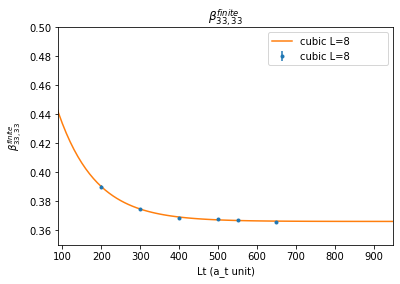

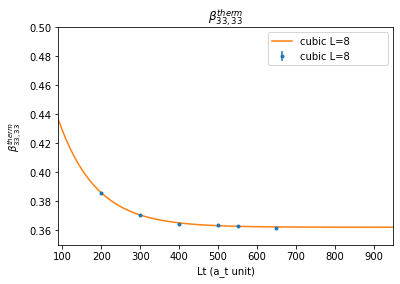

In [20]:
L=8;
plt.figure()
# fit for cubic 
result_cubic[L]['fit']={}
for beta in ['beta_fin']: 
    result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.35,0.50])
plt.xlim([90,950])
plt.legend()
plt.title(r'$\beta^{finite}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{finite}_{33,33}$') ;        

# fit for beta_therm

plt.figure()
for beta in ['beta_therm']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.35,0.50]);plt.xlim([90,950]);plt.legend()  
plt.title(r'$\beta^{therm}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{therm}_{33,33}$') ; 

### Comment
* Lt_outer=0 case, Lt<=300 seems not fit well. Fitting is done using Lt>300 points 
* Lt_outer=5 case, Lt<=200 seems not fit well. Fitting is done using Lt>=300 points. 

## Plot results L=9

L=9  Lt_outer=0
Lt  beta_fin 
100  0.521221   0.000162
200  0.470995   0.000262
L=9  Lt_outer=5
Lt  beta_fin 
100  0.463608   0.000215
200  0.447605   0.000251
300  0.424708   0.000287
400  0.396886   0.000573
450  0.387530   0.000730
500  0.380883   0.000512
550  0.375959   0.001436
600  0.373989   0.000591
650  0.374974   0.001227
700  0.372265   0.000581
750  0.370296   0.001299
800  0.371527   0.000575
850  0.371527   0.000975


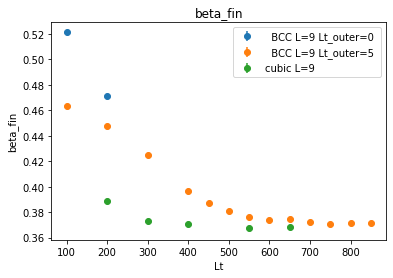

In [21]:
L=9;
# print table 
for Lto in [0,5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'beta_fin')

# plot
plt.figure()
for Lto in [0,5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'beta_fin')
    
plot_beta(result_cubic[L],L,Lto,'beta_fin',lattice='cubic')

plt.title('beta_fin')
plt.xlabel('Lt');
plt.ylabel('beta_fin')
plt.legend()  ;

  BCC L=9 Lt_outer=5      EM0 E0=150.601929 +/- 0.178651   b=505.279473  eta=0.009646  
     beta_fin= 0.370793 +/- 0.000440
     beta_therm= 0.370086 +/- 0.000439


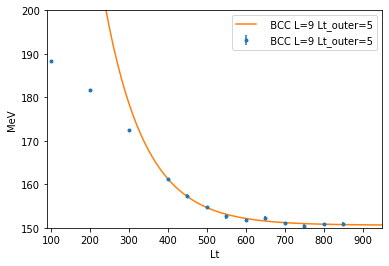

In [22]:
L=9;
p0=[150,200,0.01]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=3,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([150,200]);plt.xlim([90,950])
plt.legend()


cubic L=9            beta_fin E0=0.367786 +/- 0.000759   b=0.255180  eta=0.012562  
cubic L=9            beta_therm E0=0.364769 +/- 0.000753   b=0.253087  eta=0.012562  


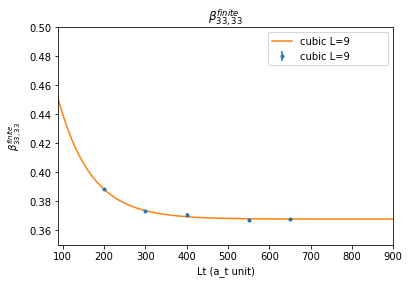

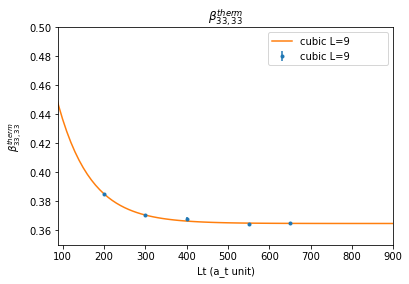

In [23]:
L=9;
plt.figure()
# fit for cubic 
result_cubic[L]['fit']={}
for beta in ['beta_fin']:    
    result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.35,0.50])
plt.xlim([90,900])
plt.legend()
plt.title(r'$\beta^{finite}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{finite}_{33,33}$') ;        

# fit for beta_therm

plt.figure()
for beta in ['beta_therm']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.35,0.50]);plt.xlim([90,900]);plt.legend()  
plt.title(r'$\beta^{therm}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{therm}_{33,33}$') ; 

### Comment
* Lt=100, 200 seems not fit well. Fitting is done omitting those.

## Plot results L=10

L=10  Lt_outer=0
Lt  beta_fin 
100  0.547066   0.000194
200  0.488376   0.000301
300  0.467089   0.000418
L=10  Lt_outer=5
Lt  beta_fin 
100  0.478037   0.000264
200  0.462528   0.000310
300  0.447627   0.000321
400  0.424516   0.000567
450  0.413569   0.000807
500  0.401405   0.000528
550  0.391674   0.001673
600  0.385592   0.000677
650  0.383767   0.001624
700  0.378294   0.000816
750  0.375557   0.001273
850  0.373732   0.000959
900  0.373428   0.001115
950  0.373428   0.001011


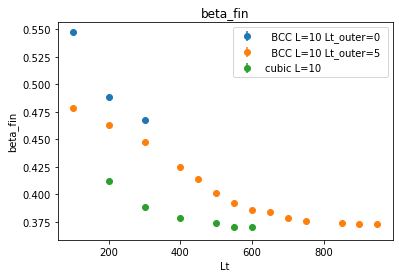

In [24]:
L=10;
# print table 
for Lto in [0,5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'beta_fin')

# plot
plt.figure()
for Lto in [0,5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'beta_fin')
    
plot_beta(result_cubic[L],L,Lto,'beta_fin',lattice='cubic')

plt.title('beta_fin')
plt.xlabel('Lt');
plt.ylabel('beta_fin')
plt.legend()  ;

  BCC L=10 Lt_outer=5      EM0 E0=122.214771 +/- 0.194186   b=360.099701  eta=0.007233  
     beta_fin= 0.371648 +/- 0.000591
     beta_therm= 0.370775 +/- 0.000589


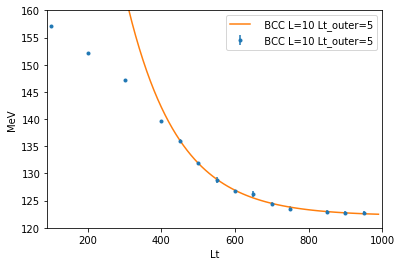

In [25]:
L=10;
p0=[150,200,0.01]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=4,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([120,160]);plt.xlim([90,1000])
plt.legend()

cubic L=10            beta_fin E0=0.368627 +/- 0.001101   b=0.192517  eta=0.007456  
cubic L=10            beta_therm E0=0.366145 +/- 0.001093   b=0.191221  eta=0.007456  


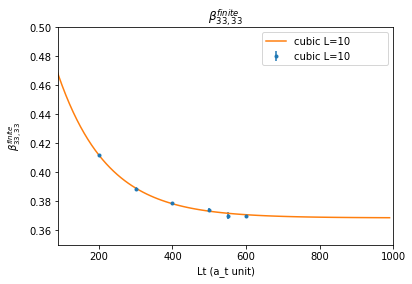

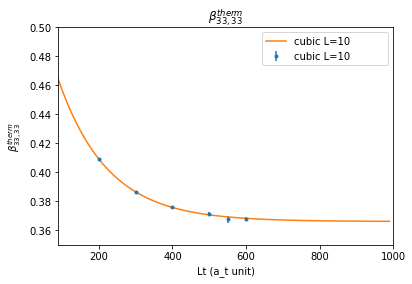

In [26]:
L=10;
plt.figure()
# fit for cubic 
result_cubic[L]['fit']={}
for beta in ['beta_fin']:   
    result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)
        
plt.ylim([0.35,0.50])
plt.xlim([90,1000])
plt.legend()
plt.title(r'$\beta^{finite}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{finite}_{33,33}$') ;        

# fit for beta_therm

plt.figure()
for beta in ['beta_therm']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)
plt.ylim([0.35,0.50]);plt.xlim([90,1000]);plt.legend()  
plt.title(r'$\beta^{therm}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{therm}_{33,33}$') ;

### Comment
* Lt<=300 points seems not fit well.
* Fitting is different if using Lt>=400 and Lt>=450 
* Also, fitting is sensitive whether to include the last point or not. 

## Plot results L=11

L=11  Lt_outer=5
Lt  beta_fin 
100  0.491410   0.000306
200  0.475213   0.000375
300  0.462698   0.000486
400  0.448342   0.000593
500  0.429201   0.000892
550  0.417054   0.001362
600  0.404539   0.001695
650  0.398281   0.002056
700  0.387974   0.001067
800  0.383925   0.002366
850  0.378036   0.001999
900  0.374723   0.004590
950  0.379876   0.001382


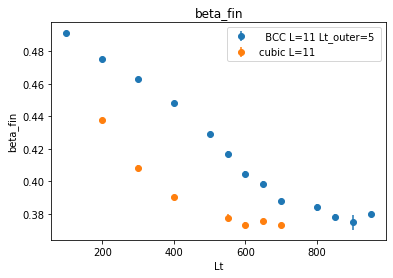

In [27]:
L=11;
# print table 
for Lto in [5]: 
    print_beta(result_bcc[L,Lto],L,Lto,'beta_fin')

# plot
plt.figure()
for Lto in [5]: 
    plot_beta(result_bcc[L,Lto],L,Lto,'beta_fin')
    
plot_beta(result_cubic[L],L,Lto,'beta_fin',lattice='cubic')

plt.title('beta_fin')
plt.xlabel('Lt');
plt.ylabel('beta_fin')
plt.legend()  ;

  BCC L=11 Lt_outer=5      EM0 E0=101.780556 +/- 0.762316   b=365.602453  eta=0.006389  
     beta_fin= 0.374651 +/- 0.002806
     beta_therm= 0.373626 +/- 0.002798


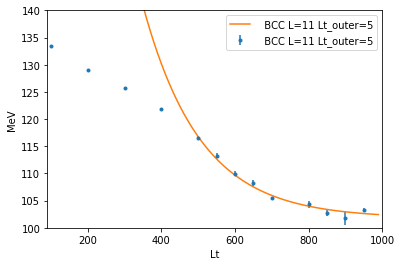

In [28]:
L=11;
p0=[100,200,0.01]

Lto=5;
E0,err,b,eta = fit_beta_Lt(result_bcc[L,Lto], L ,Lto, 'EM0'
                , lattice='BCC', p0=p0,fit_func=fit_exp
                ,fit_start_index=4,fit_end_index=None
                ,plot=True)

print('     beta_fin= %f +/- %f'%(E0/result_free[L]['EM0'],err/result_free[L]['EM0'] ))
print('     beta_therm= %f +/- %f'%(E0/result_free[L]['FG'],err/result_free[L]['FG'] ))

result_bcc['fit']['beta_fin'][L,Lto]=[E0/result_free[L]['EM0'],err/result_free[L]['EM0'],b/result_free[L]['EM0'],eta]
result_bcc['fit']['beta_therm'][L,Lto]=[E0/result_free[L]['FG'],err/result_free[L]['FG'],b/result_free[L]['FG'],eta]

plt.ylim([100,140]);plt.xlim([90,1000])
plt.legend()


cubic L=11            beta_fin E0=0.369345 +/- 0.001133   b=0.221085  eta=0.005873  
cubic L=11            beta_therm E0=0.367158 +/- 0.001126   b=0.219776  eta=0.005873  


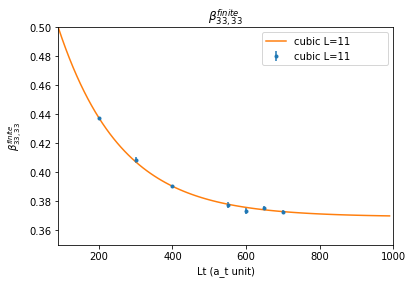

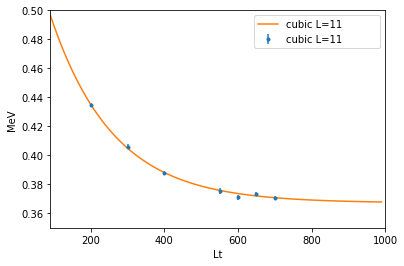

In [29]:
L=11;
plt.figure()
# fit for cubic 
result_cubic[L]['fit']={}
for beta in ['beta_fin']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)
                
plt.ylim([0.35,0.50])
plt.xlim([90,1000])
plt.legend()
plt.title(r'$\beta^{finite}_{33,33}$');
plt.xlabel('Lt (a_t unit)');
plt.ylabel(r'$\beta^{finite}_{33,33}$') ;        

# fit for beta_therm

plt.figure()
for beta in ['beta_therm']:    
        result_cubic[L]['fit'][beta]=fit_beta_Lt(result_cubic[L], L,Lto, beta,lattice='cubic',plot=True)

plt.ylim([0.35,0.50]);plt.xlim([90,1000]);plt.legend()

### Comment
* The large Lt(>=900) results of L=11 seems to be not reliable. 
* Asymptotic value is very sensitive to fit whether to include Lt=400 or the Lt=950.  
* It may be better not use L=11 results because too large uncertainty.

## L dependence of result of fitting

Plot all Beta_finite values from fitting 
with both Ltouter=0 and Ltouter=5

# Cubic Lattice case =====
#L   beta_fin           error                  beta_therm           error
5 [0.35538701446619225, 0.0002778518891388465] [0.3336944509669328, 0.0002608921441304802]
6 [0.3610147797343183, 0.00020251754398100001] [0.3502465945641269, 0.00019647707005867796]
7 [0.3630409123962919, 0.0004091983943136829] [0.35694607966394437, 0.00040232807347584024]
8 [0.36618002373068126, 0.0005474693025089439] [0.3621765601523661, 0.0005414822135657978]
9 [0.36778559433382235, 0.0007590822302707801] [0.3647687856319904, 0.0007528558996652505]
10 [0.36862709210642647, 0.0011009015943391751] [0.3661446607371729, 0.0010934791940170221]
11 [0.3693446971271922, 0.001132882974318013] [0.3671577286912271, 0.0011261749029925121]
# BCC Lto=5  =====
#L   beta_fin           error                  beta_therm           error
4 [0.3201984903692104, 0.0003020553269586361] [0.31730795511245496, 0.00029932857590163396]
5 [0.34686597265584845, 6.183339659291762e-05] [0.34434294591921344, 6.1383

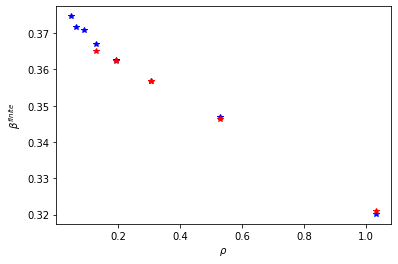

In [30]:
# show large Lt values and store 

print('# Cubic Lattice case =====')
print('#L   beta_fin           error                  beta_therm           error')

L_cubic=[];beta_fin_cubic=[]; beta_therm_cubic=[];
for L in [5,6,7,8,9,10,11]:
    print(L, result_cubic[L]['fit']['beta_fin'][:2], result_cubic[L]['fit']['beta_therm'][:2]  )
    L_cubic.append(L)
    beta_fin_cubic.append(result_cubic[L]['fit']['beta_fin'][:2])
    beta_therm_cubic.append(result_cubic[L]['fit']['beta_therm'][:2] )
    
print('# BCC Lto=5  =====')    
print('#L   beta_fin           error                  beta_therm           error')
for L in [4,5,6,7,8,9,10,11]:
    Lto=5
    print(L, result_bcc['fit']['beta_fin'][L,Lto][:2],result_bcc['fit']['beta_therm'][L,Lto][:2] )
    
print('#L  BCC Lto=0 ======')    
print('#L   beta_fin           error                  beta_therm           error')
for L in [4,5,6,7,8]:
    Lto=0
    print(L, result_bcc['fit']['beta_fin'][L,Lto][:2], result_bcc['fit']['beta_therm'][L,Lto][:2])
    
#----plot       
for L in [4,5,6,7,8,9,10,11]:
    Lto=5
    plt.plot(66/L**3,result_bcc['fit']['beta_fin'][L,Lto][0],'b*')
    #plt.plot(66/L**3,result_bcc[L,Lto]['fit']['beta_therm'][0],'.')   
for L in [4,5,6,7,8]:
    Lto=0
    plt.plot(66/L**3,result_bcc['fit']['beta_fin'][L,Lto][0],'r*')
    #plt.plot(66/L**3,result_bcc[L,Lto]['fit']['beta_therm'][0],'.')  

plt.xlabel(r'$\rho$')
plt.ylabel(r'$\beta^{finite}$')
print('********************************')
print('Blue points are Ltouter=5 cases')
print('Red points are Ltouter=0 cases')

## Select results of fits
* As increasing, the ratio increase except the case of L=9 BCC with Lt_outer=5.
* Lt_outer dependence should be not important. 
  We may choose either results for each L.
  For example, we may choose Lt_outer=0 values for L=4
  and Lt_outer=5 values for other L. 
* L=9 BCC Lt_outer=5 seems to have larger uncertainty. 
* L=11 result may be not reliable. So, let us not use this.   

In [31]:
#Selecting data
L_bcc=[4,5,6,7,8,9,10] # do not use L=11. L=9 too??
beta_fin_bcc=[];beta_therm_bcc=[];        
#L=4 case use Lto=0 results
beta_fin_bcc.append(result_bcc['fit']['beta_fin'][4,0][:2]) 
beta_therm_bcc.append(result_bcc['fit']['beta_therm'][4,0][:2]) 
# L>=5 case use Lto=5 results
for L in L_bcc[1:]:
    if L< 8 :
        Lto=5  # L>=5 case, use Lt_outer=5 results 
        beta_fin_bcc.append(result_bcc['fit']['beta_fin'][L,Lto][:2]) 
        Lto=5
        beta_therm_bcc.append(result_bcc['fit']['beta_therm'][L,Lto][:2]) 
    if L==8 : # test for choosing Lto=0?
        Lto=5
        beta_fin_bcc.append(result_bcc['fit']['beta_fin'][L,Lto][:2]) 
        Lto=5
        beta_therm_bcc.append(result_bcc['fit']['beta_therm'][L,Lto][:2]) 
    if L>8:
        Lto=5
        beta_fin_bcc.append(result_bcc['fit']['beta_fin'][L,Lto][:2]) 
        beta_therm_bcc.append(result_bcc['fit']['beta_therm'][L,Lto][:2]) 
# convert into array 
L_cubic=np.array(L_cubic)
beta_fin_cubic=np.array(beta_fin_cubic)
beta_therm_cubic=np.array(beta_therm_cubic)
L_bcc=np.array(L_bcc)
beta_fin_bcc=np.array(beta_fin_bcc)
beta_therm_bcc=np.array(beta_therm_bcc)

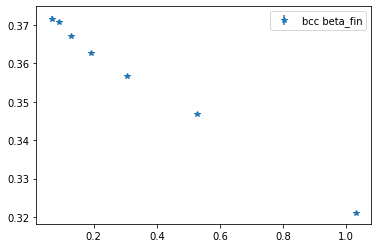

In [32]:
plt.errorbar(66/L_bcc**3, beta_fin_bcc[:,0], yerr=beta_fin_bcc[:,1],fmt='*',label='bcc beta_fin')
#plt.errorbar(66/L_bcc[:]**3, beta_therm_bcc[:,0],yerr=beta_therm_bcc[:,1],fmt='*',label='bcc beta_therm')
#plt.errorbar(66/L_cubic**3, beta_fin_cubic[:,0],yerr=beta_fin_cubic[:,1],fmt='*',label='cubic beta_fin')
#plt.errorbar(66/L_cubic**3, beta_therm_cubic[:,0],yerr=beta_therm_cubic[:,1],fmt='*',label='cubic beta_therm')
plt.legend()
#plt.xlim([0,1.1])
#plt.ylim([0.33,0.375])

## Fitting the density dependence

### fitting functions

In [33]:
def Lfit_fn1(rho,c,a1,a2):
    return a1*rho+a2*rho**(2./3.)+c

def Lfit_fn2(rho,c,a1,a2):
    return a1*rho+a2*rho**(4./3.)+c

def Lfit_fn3(rho,c,a1,a2):
    return a1*rho+a2*rho**(1./3.)+c

def Lfit_fn4(rho,c,a1,a2):
    return a1*rho+a2*rho**(5./3.)+c


## Fitting of cubic results

beta_fin c=0.372383 +/- 0.001872
beta_fin c=0.370865 +/- 0.001211
beta_therm c=0.368251 +/- 0.001883
beta_therm c=0.369455 +/- 0.001083


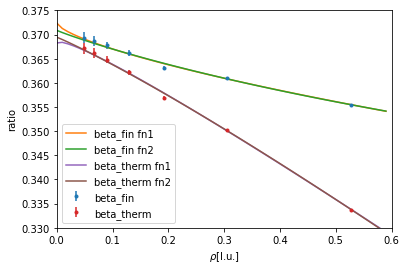

In [34]:
# Fitting rho dependence 
# cubic beta_fin 
rho_cubic=66/(L_cubic**3)
plt.errorbar(rho_cubic,beta_fin_cubic[:,0],yerr=beta_fin_cubic[:,1], fmt='.', label='beta_fin')
# fit function 1
params, p_covariance = optimize.curve_fit(Lfit_fn1, rho_cubic, 
                                beta_fin_cubic[:,0], sigma=beta_fin_cubic[:,1],
                                p0=[0.37, -0.01,-0.01])
print('beta_fin c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
xx = np.arange(0,0.6,0.01)
ff = Lfit_fn1(xx,*params)
plt.plot(xx,ff,label='beta_fin fn1'  )
# fit function 2
params, p_covariance = optimize.curve_fit(Lfit_fn2, rho_cubic, 
                                beta_fin_cubic[:,0], sigma=beta_fin_cubic[:,1],
                                p0=[0.37, -0.01,-0.01])
print('beta_fin c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
xx = np.arange(0,0.6,0.01)
ff = Lfit_fn2(xx,*params)
plt.plot(xx,ff,label='beta_fin fn2'  )

# cubic beta_therm 
plt.errorbar(rho_cubic,beta_therm_cubic[:,0],yerr=beta_therm_cubic[:,1], fmt='.', label='beta_therm')
# fit function 1
params, p_covariance = optimize.curve_fit(Lfit_fn1, rho_cubic, 
                                beta_therm_cubic[:,0], sigma=beta_therm_cubic[:,1],
                                p0=[0.37, -0.01,-0.01])
print('beta_therm c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
xx = np.arange(0,0.6,0.01)
ff = Lfit_fn1(xx,*params)
plt.plot(xx,ff,label='beta_therm fn1'  )
# fit function 2
params, p_covariance = optimize.curve_fit(Lfit_fn2, rho_cubic, 
                                beta_therm_cubic[:,0], sigma=beta_therm_cubic[:,1],
                                p0=[0.37, -0.01,-0.01])
print('beta_therm c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
xx = np.arange(0,0.6,0.01)
ff = Lfit_fn2(xx,*params)
plt.plot(xx,ff,label='beta_therm fn2'  )

plt.legend()
plt.xlim([0,0.6])
plt.ylim([0.33,0.375])
plt.ylabel('ratio')
plt.xlabel(r'$\rho$[l.u.]')
plt.legend()

## Fitting of BCC results with fitting function 1

beta_fin c=0.372929 +/- 0.002242


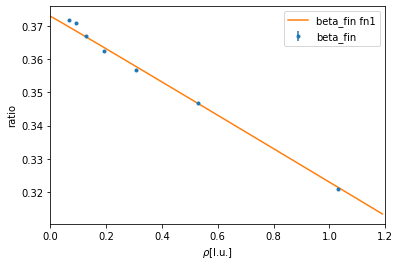

In [35]:
# Fitting rho dependence 
# bcc beta_fin 
rho_bcc=66/(L_bcc**3)
dat_x=rho_bcc[:]
dat_y=beta_fin_bcc[:,0]
dat_yerr=beta_fin_bcc[:,1]
plt.errorbar(rho_bcc,beta_fin_bcc[:,0],yerr=beta_fin_bcc[:,1], fmt='.', label='beta_fin')
xx = np.arange(0,1.2,0.01)

# fit function 1
params, p_covariance = optimize.curve_fit(Lfit_fn1, dat_x, dat_y, sigma=dat_yerr,
                                p0=[0.37, -0.01,-0.01])
print('beta_fin c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )

ff = Lfit_fn1(xx,*params)
plt.plot(xx,ff,label='beta_fin fn1'  )

#ff2=ratio_fit(xx,*ratio_fit_para)*ff
#plt.plot(xx,ff2,label='beta_therm ratio_fit' )

## bcc beta_therm 
#dat_x=rho_bcc[:]
#dat_y=beta_therm_bcc[:,0]
#dat_yerr=beta_therm_bcc[:,1]
#plt.errorbar(rho_bcc,beta_therm_bcc[:,0],yerr=beta_therm_bcc[:,1], fmt='.', label='beta_therm')
## fit function 1
#params, p_covariance = optimize.curve_fit(Lfit_fn1, dat_x,dat_y, sigma=dat_yerr,
#                                p0=[0.37, -0.01,-0.01])
#print('beta_therm c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
#ff = Lfit_fn1(xx,*params)
#plt.plot(xx,ff,label='beta_therm fn1'  )


plt.legend()
plt.xlim([0,1.2])
#plt.ylim([0.30,0.375])
plt.ylabel('ratio')
plt.xlabel(r'$\rho$[l.u.]')
plt.legend()

## Fitting of BCC results with fitting function 2

beta_fin c=0.372811 +/- 0.001355


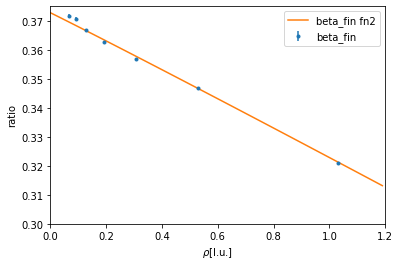

In [36]:
# Fitting rho dependence 
# bcc beta_fin 
rho_bcc=66/(L_bcc**3)
dat_x=rho_bcc[:]
dat_y=beta_fin_bcc[:,0]
dat_yerr=beta_fin_bcc[:,1]
plt.errorbar(rho_bcc,beta_fin_bcc[:,0],yerr=beta_fin_bcc[:,1], fmt='.', label='beta_fin')
xx = np.arange(0,1.2,0.01)

# fit function 2
params, p_covariance = optimize.curve_fit(Lfit_fn2, dat_x,dat_y, sigma=dat_yerr,
                                p0=[0.37, -0.01,-0.01])
print('beta_fin c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
ff = Lfit_fn2(xx,*params)
plt.plot(xx,ff,label='beta_fin fn2'  )

## bcc beta_therm 
#dat_x=rho_bcc[:]
#dat_y=beta_therm_bcc[:,0]
#dat_yerr=beta_therm_bcc[:,1]
#plt.errorbar(rho_bcc,beta_therm_bcc[:,0],yerr=beta_therm_bcc[:,1], fmt='.', label='beta_therm')
## fit function 2
#params, p_covariance = optimize.curve_fit(Lfit_fn2, dat_x,dat_y, sigma=dat_yerr,
#                                p0=[0.37, -0.01,-0.01])
#print('beta_therm c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
#ff = Lfit_fn2(xx,*params)
#plt.plot(xx,ff,label='beta_therm fn2'  )

plt.legend()
plt.xlim([0,1.2])
plt.ylim([0.30,0.375])
plt.ylabel('ratio')
plt.xlabel(r'$\rho$[l.u.]')
plt.legend()

## Fitting of BCC results with fitting function 3

beta_fin c=0.373211 +/- 0.004160


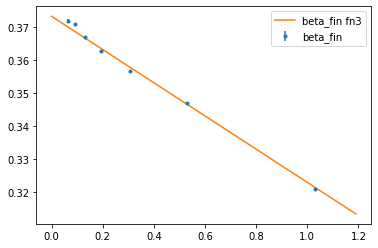

In [37]:
# Fitting rho dependence 
# bcc beta_fin 
rho_bcc=66/(L_bcc**3)
dat_x=rho_bcc[:]
dat_y=beta_fin_bcc[:,0]
dat_yerr=beta_fin_bcc[:,1]
plt.errorbar(rho_bcc,beta_fin_bcc[:,0],yerr=beta_fin_bcc[:,1], fmt='.', label='beta_fin')
xx = np.arange(0,1.2,0.01)
# fit function 1
params, p_covariance = optimize.curve_fit(Lfit_fn3, dat_x, dat_y, sigma=dat_yerr,
                                p0=[0.37, 0.01, 0.01])
print('beta_fin c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )

ff = Lfit_fn3(xx,*params)
plt.plot(xx,ff,label='beta_fin fn3'  )

## bcc beta_therm 
#dat_x=rho_bcc[:]
#dat_y=beta_therm_bcc[:,0]
#dat_yerr=beta_therm_bcc[:,1]
#plt.errorbar(rho_bcc,beta_therm_bcc[:,0],yerr=beta_therm_bcc[:,1], fmt='.', label='beta_therm')
## fit function 1
#params, p_covariance = optimize.curve_fit(Lfit_fn3, dat_x,dat_y, sigma=dat_yerr,
#                                p0=[0.37, -0.01,-0.01])
#print('beta_therm c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
#ff = Lfit_fn3(xx,*params)
#plt.plot(xx,ff,label='beta_therm fn3'  )

plt.legend()

## Fitting of BCC results with fitting function 4

beta_fin c=0.372487 +/- 0.001352


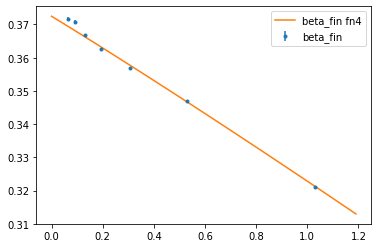

In [38]:

# Fitting rho dependence 
# bcc beta_fin 
rho_bcc=66/(L_bcc**3)
dat_x=rho_bcc[:-1]
dat_y=beta_fin_bcc[:-1,0]
dat_yerr=beta_fin_bcc[:-1,1]
plt.errorbar(rho_bcc,beta_fin_bcc[:,0],yerr=beta_fin_bcc[:,1], fmt='.', label='beta_fin')
xx = np.arange(0,1.2,0.01)
# fit function 1
params, p_covariance = optimize.curve_fit(Lfit_fn4, dat_x, dat_y, sigma=dat_yerr,
                                p0=[0.37, 0.01, 0.01])
print('beta_fin c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )

ff = Lfit_fn4(xx,*params)
plt.plot(xx,ff,label='beta_fin fn4'  )

## bcc beta_therm 
#dat_x=rho_bcc[:-1]
#dat_y=beta_therm_bcc[:-1,0]
#dat_yerr=beta_therm_bcc[:-1,1]
#plt.errorbar(rho_bcc,beta_therm_bcc[:,0],yerr=beta_therm_bcc[:,1], fmt='.', label='beta_therm')
## fit function 1
#params, p_covariance = optimize.curve_fit(Lfit_fn4, dat_x,dat_y, sigma=dat_yerr,
#                                p0=[0.37, -0.01,-0.01])
#print('beta_therm c=%f +/- %f'%(params[0],np.sqrt(p_covariance[0,0]))  )
#ff = Lfit_fn4(xx,*params)
#plt.plot(xx,ff,label='beta_therm fn3'  )

plt.legend()